<a href="https://colab.research.google.com/github/ikhsanmn/brain_tumor_detection_machine_learning/blob/main/project_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

Import the required library and rename them by "as" for convenience.  
プログラムに必要なライブラリを "import" によって使用可能にします。  
また、"as" を用いることで名前を変更し、今後の呼び出しをラクにしています。

In [ ]:
import tensorflow as tf #
import pandas as pd # pandas is useful for handling dataset as "Data frame"
import numpy as np # numpy required as input like "array"
import seaborn as sns #seabor is useful for making visualization of data before and after processing
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3 #is a model that can be used for image classification tasks.
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet # import tools that densenet
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet #import tools that resnet
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception #import tools for
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers

Using the "pandas" library, multiple data can be combined to create a "data frame(df)". This type of data is used to manage data like a table.  
In this case, the data frame manages the "location of the image" and the "disease that the image depicts".  
"pandas"というライブラリを用いることで、複数のデータを合体させて"データフレーム(df)"を作ることができます。  
これは表のようにデータを管理する型であり、今回は"画像の保存場所"と"その画像が写している疾患"の２つをデータフレームによって管理します。

Following kaggle's notebook, the storage location of the dataset is defined as follows.  
kaggleのnotebookに倣って、データセットの保存場所は以下のように定義します。

In [ ]:
dataset_path = "./kaggle/input/brain-tumor-dataset"
train_dir = os.path.join(dataset_path, "Training") # os.path.join is used to generate a path connecting "dataset_path" and the string "Training".
test_dir = os.path.join(dataset_path, "Testing") # os.path.join を用いて、dataset_path と 文字列 Testing をつなげたパスを生成しています。

To use the kaggle dataset on google colab, download the dataset using the kaggle API.  
The token used here can be obtained from your kaggle profile.  
kaggleのデータセットをgoogle colab上で使用するために、kaggle API を用いてデータセットをダウンロードします。  
ここで使用するトークンはkaggleのプロフィールから取得できます。

In [ ]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 79% 117M/149M [00:00<00:00, 1.22GB/s]
100% 149M/149M [00:00<00:00, 1.12GB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  

In [ ]:
!mkdir -p ./kaggle/input/brain-tumor-dataset
!mv Testing ./kaggle/input/brain-tumor-dataset
!mv Training ./kaggle/input/brain-tumor-dataset

The following code cell defines the function "create_dataframe", which creates a dataframe for the files in a folder by passing the path "directory" of the folder where the data set will be stored.  
次のコードセルでは、データセットの保存先であるフォルダのパス directory を渡すことで、そのフォルダ内のファイルに対してデータフレームを作成する関数 create_dataframe を定義しています。

In [ ]:
def create_dataframe(directory):
    image_paths = []
    labels = []

    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)

        if not os.path.isdir(category_path):
            continue

        for img_file in glob.glob(os.path.join(category_path, "*.jpg")):
            image_paths.append(img_file)
            labels.append(category)

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    return df

Using the function "create_dataflame" defined earlier, actually generate dataframes for training and testing, respectively.  
先ほど定義した create_dataflame を用いて、実際に訓練用とテスト用のデータフレームをそれぞれ生成します。

In [ ]:
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

The data frame can be used to check the total data and the number of data per label as follows.  
データフレームを用いて、データの合計やラベルごとのデータ数を以下のように確認できます。

In [ ]:
print(f"Number of training data: {len(train_df)}")
print(f"Number of testing data: {len(test_df)}")
print("\nNumber of training data per category:")
print(train_df['label'].value_counts())
print("\nNumber of testing data per category:")
print(test_df['label'].value_counts())

Number of training data: 5712
Number of testing data: 1311

Number of training data per category:
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

Number of testing data per category:
label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64


The actual data frame structure can be seen in the following code.  
実際のデータフレームの構造は以下のコードで確認できます。

In [ ]:
print("\nExamples of training data frame:")
print(train_df.head())


Examples of training data frame:
                                          image_path   label
0  ./kaggle/input/brain-tumor-dataset/Training/gl...  glioma
1  ./kaggle/input/brain-tumor-dataset/Training/gl...  glioma
2  ./kaggle/input/brain-tumor-dataset/Training/gl...  glioma
3  ./kaggle/input/brain-tumor-dataset/Training/gl...  glioma
4  ./kaggle/input/brain-tumor-dataset/Training/gl...  glioma


### simple model

To submit a working program for now, a very simple model is built below. The accuracy is quite low, so a small improvement would be effective.  
とりあえず動くプログラムを提出するため、非常に単純なモデルを以下に構築します。精度はかなり低いので、ちょっとした改善で効果が出ると思います。

In the following code cell, some samples are first visualized by displaying them via matplotlib.  
以下のコードセルでは、まずいくつかのサンプルを matplotlib によって表示することで、可視化を行っています。

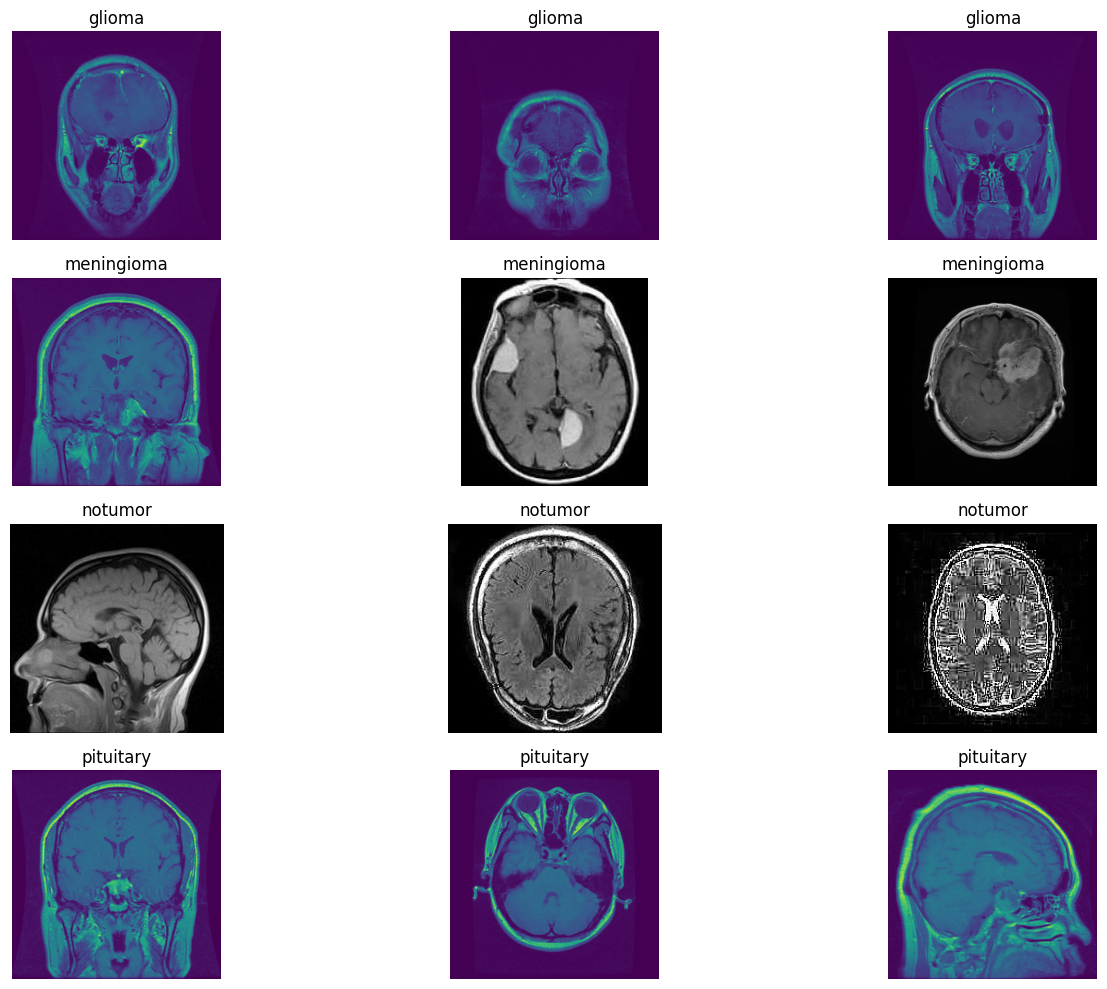

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(15, 10))
n_sample = 3; # the number of visualized samples

for i, class_name in enumerate(labels):
  class_df = train_df[train_df['label'] == class_name].sample(n_sample)

  for j, (_, row) in enumerate(class_df.iterrows()):
    img = plt.imread(row['image_path'])
    plt.subplot(len(labels), n_sample, i * n_sample + j + 1)
    plt.imshow(img)
    plt.title(f"{class_name}")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

The next step is to define the image size and perform (very simple) preprocessing of the training and test data.  
次に、画像サイズの決定と、訓練用データとテスト用データの（非常に簡易的な）前処理を定義します。

In [ ]:
img_height = 150
img_width = 150
batch_size = 32 # the number of samples that be processed at once

"""
Data Argumentation of an image is performed by means of a slight geometric transformation.
わずかな幾何変換によって画像のデータ拡張を行います。
"""

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

The data extension defined by datagen is actually executed on the data frame by the following code.  
datagen によって定義したデータ拡張を、以下のコードによって、実際にデータフレームに対して実行します。

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
)

Found 4570 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
print("The index mapping of classes:")
print(train_generator.class_indices)

The index mapping of classes:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


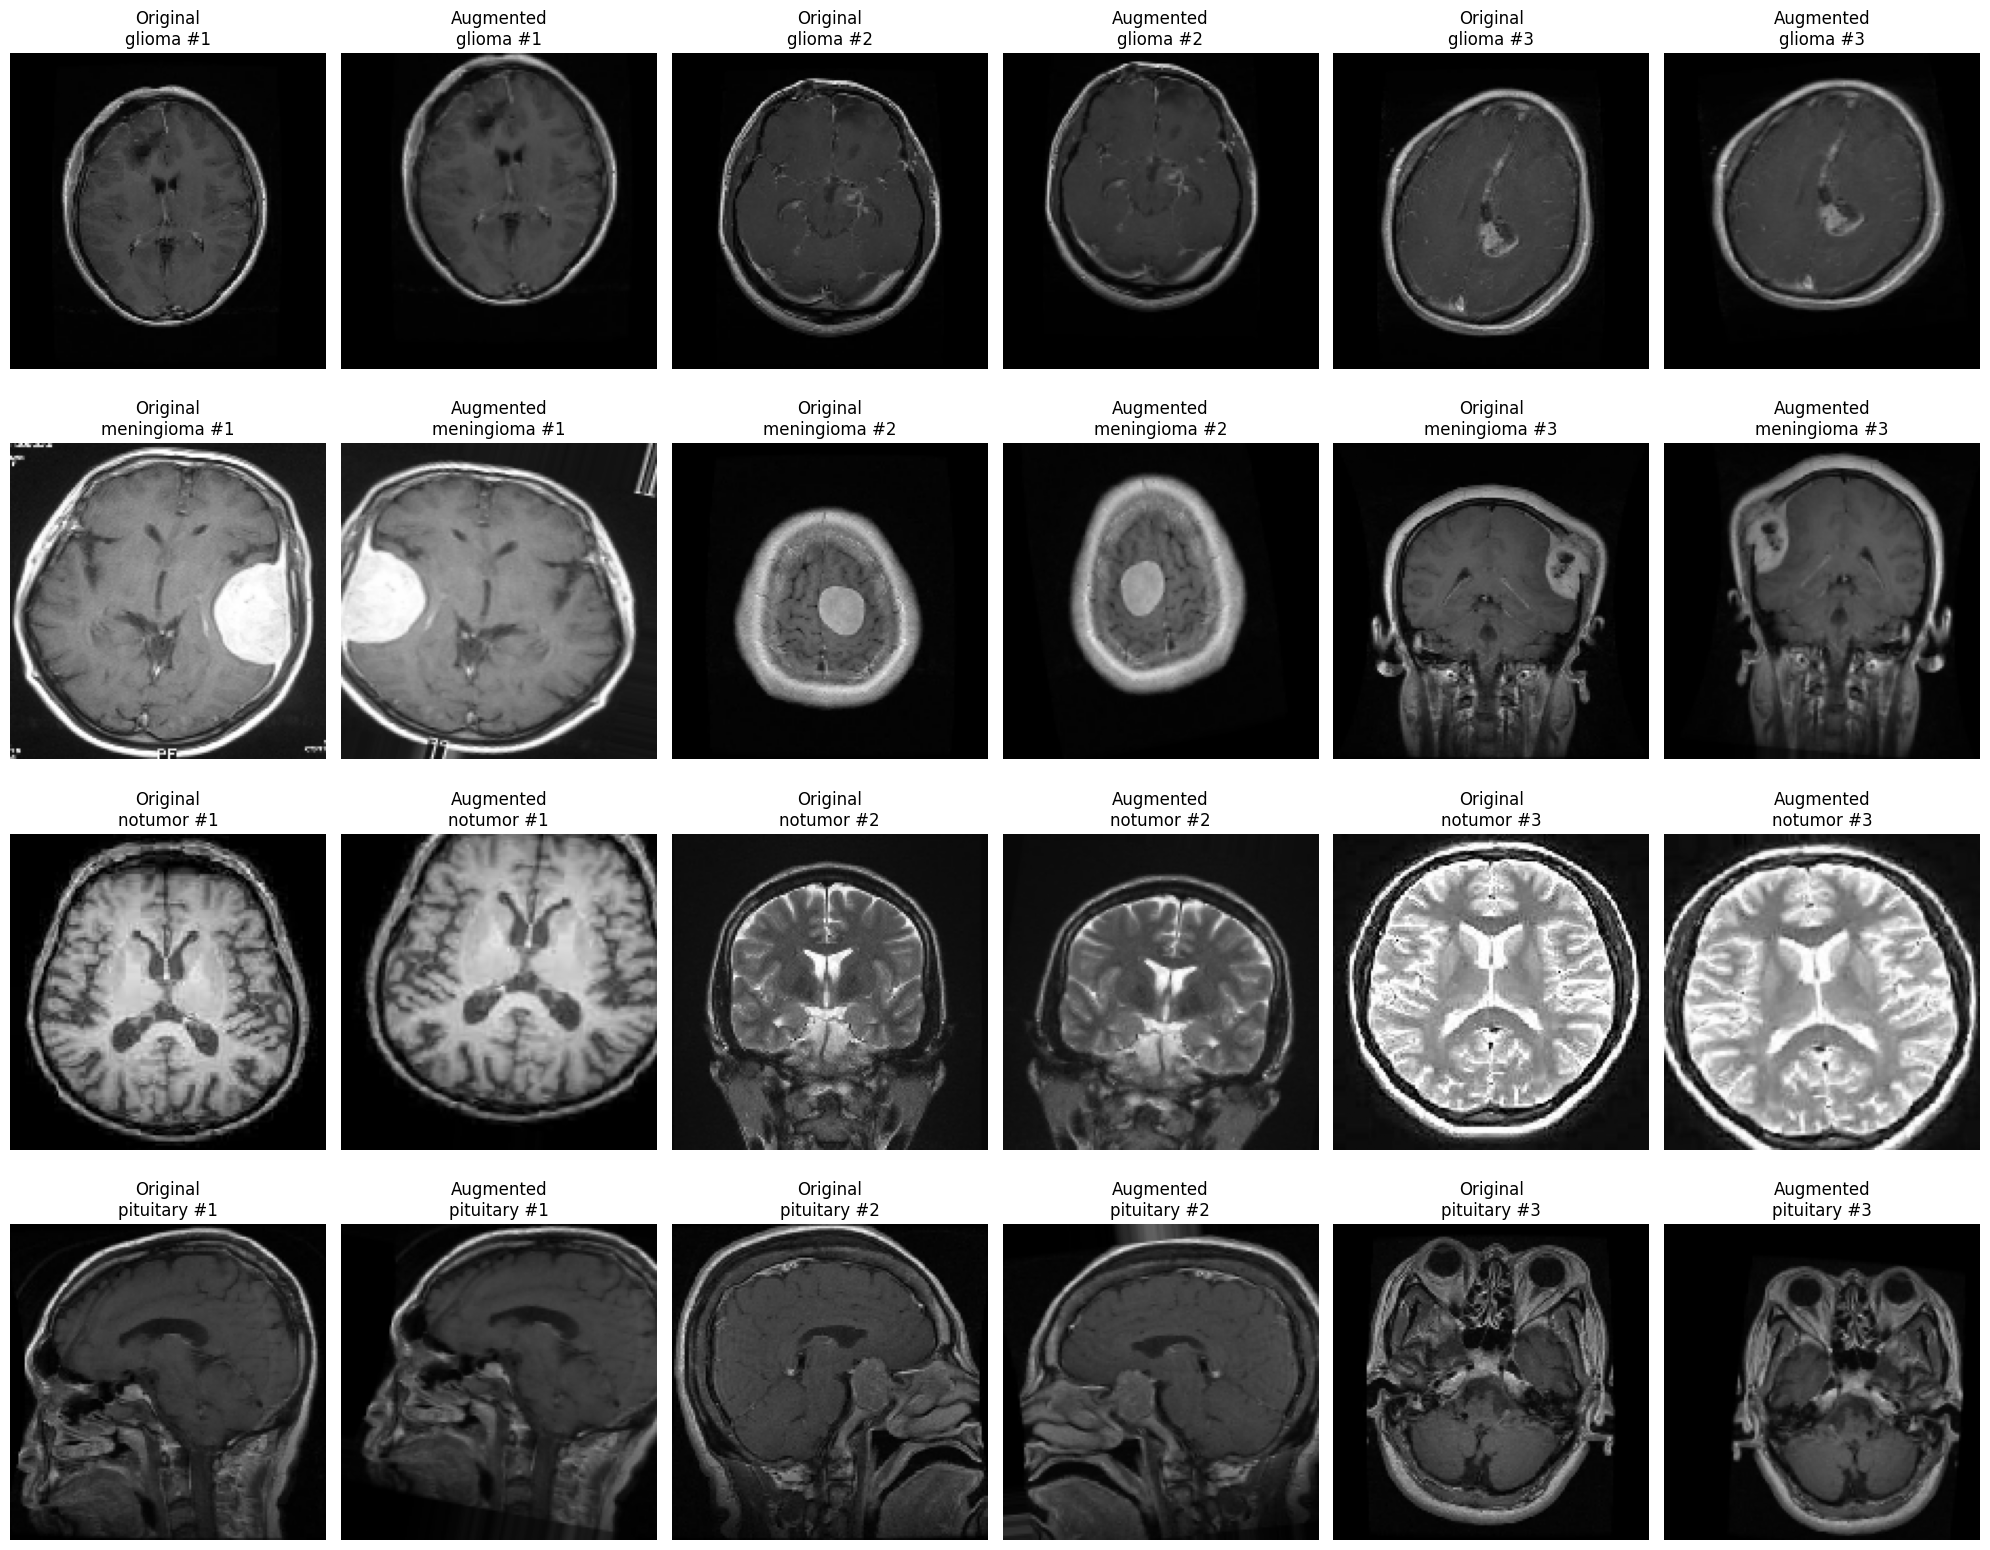

In [ ]:
def plot_augmented_images(generator, num_samples_per_class=3):

    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

    plt.figure(figsize=(20, 16))

    generator.reset()

    class_files = {label: [] for label in labels}

    for filename in generator.filenames:
        label_name = os.path.basename(os.path.dirname(filename))
        if label_name in class_files and len(class_files[label_name]) < num_samples_per_class:
            class_files[label_name].append(filename)

    plot_index = 1

    for class_idx, class_name in enumerate(labels):
        files_for_class = class_files[class_name]

        for sample_idx in range(min(num_samples_per_class, len(files_for_class))):
            img_path = files_for_class[sample_idx]

            original_img = tf.keras.preprocessing.image.load_img(
                img_path,
                target_size=(generator.target_size[0], generator.target_size[1])
            )
            original_img_array = tf.keras.preprocessing.image.img_to_array(original_img)
            original_img_normalized = original_img_array / 255.0

            augmented_img_array = generator.image_data_generator.random_transform(original_img_array)
            augmented_img_array = generator.image_data_generator.standardize(augmented_img_array)

            plt.subplot(len(labels), num_samples_per_class * 2, plot_index)
            plt.imshow(original_img_normalized)
            plt.title(f"Original\n{class_name} #{sample_idx + 1}")
            plt.axis('off')

            plt.subplot(len(labels), num_samples_per_class * 2, plot_index + 1)
            plt.imshow(augmented_img_array)
            plt.title(f"Augmented\n{class_name} #{sample_idx + 1}")
            plt.axis('off')

            plot_index += 2

    plt.tight_layout()
    plt.savefig('augmented_comparison_by_class.png')
    plt.show()

plot_augmented_images(train_generator)

In [ ]:
from tensorflow.keras import layers, models, optimizers
def build_model(input_shape=(150, 150, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model(input_shape=(img_height, img_width, 3), num_classes=len(labels))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 15

callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_brain_tumor_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )

Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8637 - loss: 0.4024
Epoch 1: val_accuracy improved from -inf to 0.23750, saving model to best_brain_tumor_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 638ms/step - accuracy: 0.8636 - loss: 0.4024 - val_accuracy: 0.2375 - val_loss: 1.3792
Epoch 2/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.8750 - loss: 0.2672
Epoch 2: val_accuracy did not improve from 0.23750
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.8750 - loss: 0.2672 - val_accuracy: 0.2098 - val_loss: 1.5048
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8637 - loss: 0.3931
Epoch 3: val_accuracy did not improve from 0.23750
142/142 ━━━━━━━━━━━━━━━━━━━━ 89s 626ms/step - accuracy: 0.8637 - loss: 0.3932 - val_accuracy: 0.0071 - val_loss: 2.2295
Epoch 4/15
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.8438 - loss: 0.4175
Epoch 4: val_accuracy did not improve from 0.23750
142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.8438 - loss: 0.4175 - val_accuracy: 0.0054 - val_loss: 2.2430


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)

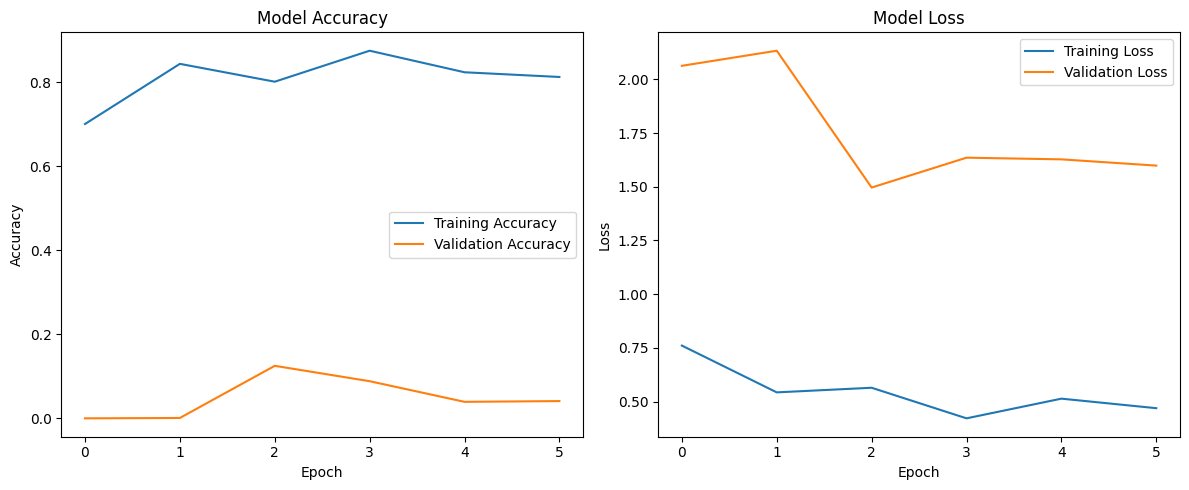

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_learning_curves(history)

In [ ]:
_, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.3056 - loss: 2.1351
Test accuracy: 0.5248


In [ ]:
test_generator.reset()
y_pred = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / batch_size)))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.72      0.07      0.13       300
  meningioma       0.51      0.36      0.42       306
     notumor       0.47      0.99      0.64       405
   pituitary       0.73      0.52      0.61       300

    accuracy                           0.52      1311
   macro avg       0.61      0.48      0.45      1311
weighted avg       0.60      0.52      0.46      1311



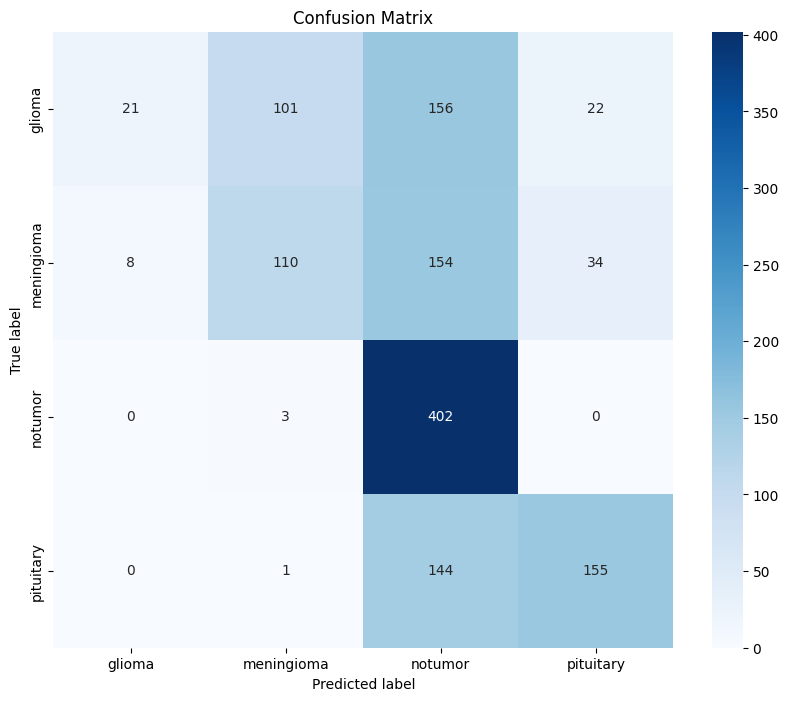

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
def visualize_predictions(model, test_df, classes, img_height=150, img_width=150, num_samples=8):
    samples = test_df.sample(num_samples)

    plt.figure(figsize=(15, 12))

    for i, (_, row) in enumerate(samples.iterrows()):
        print(row)
        img_path = row['image_path']
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]
        true_class = row['label']
        print(true_class)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        color = 'green' if labels[predicted_class] == true_class else 'red'
        plt.title(f"true label: {true_class}\nprediction: {labels[predicted_class]}\nconfidence: {confidence:.2f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()

visualize_predictions(model, test_df, labels, img_height, img_width)

### Functions

simple_model で使用した関数などを定義したセルを以下にまとめます。  
つまり、このセクションのセルを一括で実行すれば、ライブラリをインポートするように、関数を流用できます。  
入力画像サイズは256x256、バッチサイズは32がデフォルトとなっています。

[定義される処理]
- ImageDataGenerator を用いたテストデータ（検証データ）の拡張、各データの正規化
- モデル構築関数 bulid_model(input_size, num_classes)
- 学習曲線プロット関数 plot_learning_curves(history)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 256
img_width = 256
batch_size = 32

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
)

def build_model(input_shape=(150, 150, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

def visualize_predictions(model, test_df, classes, img_height=150, img_width=150, num_samples=8):
    samples = test_df.sample(num_samples)

    plt.figure(figsize=(15, 12))

    for i, (_, row) in enumerate(samples.iterrows()):
        print(row)
        img_path = row['image_path']
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(img_height, img_width)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class]
        true_class = row['label']
        print(true_class)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        color = 'green' if labels[predicted_class] == true_class else 'red'
        plt.title(f"true label: {true_class}\nprediction: {labels[predicted_class]}\nconfidence: {confidence:.2f}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()


Found 4570 validated image filenames belonging to 4 classes.
Found 1142 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


### reserch for parameter

エポック数を増やした際の学習曲線を分析します．過学習防止用のcallbackを調整して検証

In [ ]:
model = build_model(input_shape=(img_height, img_width, 3), num_classes=len(labels))

callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_brain_tumor_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callbacks
    )

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8600 - loss: 0.3932
Epoch 1: val_accuracy improved from 0.23750 to 0.26696, saving model to best_brain_tumor_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 90s 636ms/step - accuracy: 0.8600 - loss: 0.3932 - val_accuracy: 0.2670 - val_loss: 1.8713
Epoch 2/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.9062 - loss: 0.2265
Epoch 2: val_accuracy improved from 0.26696 to 0.27054, saving model to best_brain_tumor_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.9062 - loss: 0.2265 - val_accuracy: 0.2705 - val_loss: 1.8449
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8565 - loss: 0.4089
Epoch 3: val_accuracy improved from 0.27054 to 0.40000, saving model to best_brain_tumor_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8566 - loss: 0.4088 - val_accuracy: 0.4000 - val_loss: 1.3761
Epoch 4/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8438 - loss: 0.4565
Epoch 4: val_accuracy did not improve from 0.40000
142/142 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.8438 - loss: 0.4565 - val_accuracy: 0.3732 - val_loss: 1.4270
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8695 - loss: 0.3618
Epoch 5: val_accuracy did not improve from 0.40000
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 715ms/step - accuracy: 0.8695 - loss: 0.3619 - val_accuracy: 0.3545 - val_loss: 1.5089
Epoch 6/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8438 - loss: 0.4069
Epoch 6: val_accuracy improved from 0.40000 to 0.40625, saving model to best_brain_tumor_model.h5


142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.8438 - loss: 0.4069 - val_accuracy: 0.4062 - val_loss: 1.4078


In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_learning_curves(history)

In [ ]:
import time

start_time = time.time()

model = build_model(input_shape=(img_height, img_width, 3), num_classes=len(labels))
model.load_weights('best_brain_tumor_model.h5')

_, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

test_generator.reset()
y_pred = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / batch_size)))
end_time = time.time()
print(f"Computation Time: {end_time - start_time:.2f} seconds")
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (epoch=100)')
plt.savefig('confusion_matrix.png')
plt.show()

さらにエポック数を増やします．

In [ ]:
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=1000,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=callback
    )

plot_learning_curves(history)
_, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

test_generator.reset()
y_pred = model.predict(test_generator, steps=int(np.ceil(test_generator.samples / batch_size)))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (epoch=1000)')
plt.savefig('confusion_matrix.png')
plt.show()

### preprocess v05_13

In addition to the current preprocessing (normalization, geometric transformation), we have created a preprocess_mri_dataset function that performs Gaussian noise attachment, contrast adjustment, and histogram flattening (CLAHE).   
The contrast adjustment enhances the border between the brain tissue and the tumor, and the histogram flattening adjusts the brightness for dark images.  
Hopefully this will be effective in training the model.  

現在行っている前処理（正規化，幾何変換）に加え，ガウシアンノイズの添付とコントラストの調整，ヒストグラム平坦化（CLAHE）を行う関数 preprocess_mri_dataset を作成しました．   
コントラストを調整することで，脳組織と腫瘍の境目がより強調され，またヒストグラム平坦化により暗い画像に対しても明るさが調整されます．  
これがモデルの学習に効果的であることを祈るばかりです．

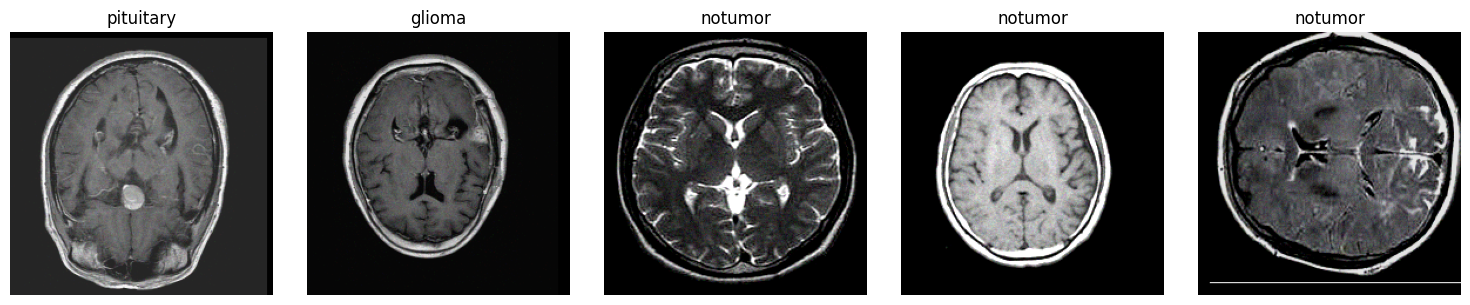

In [ ]:
import random
from sklearn.model_selection import train_test_split

def preprocess_mri_dataset(train_df, img_size=(224, 224), validation_split=0.2, batch_size=32,
                         add_noise=True, noise_sigma=0.03, apply_hist_eq=True,
                         apply_clahe_eq=True, use_data_augmentation=True, seed=42):

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    class_mapping = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

    train_data, val_data = train_test_split(
        train_df,
        test_size=validation_split,
        stratify=train_df['label'],
        random_state=seed
    )

    def preprocess_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)

        img = tf.image.resize(img, img_size)

        img = tf.cast(img, tf.float32) / 255.0

        min_val = tf.reduce_min(img)
        max_val = tf.reduce_max(img)
        img = (img - min_val) / (tf.maximum(max_val - min_val, 1e-7))

        if apply_hist_eq:
            img = tf.image.adjust_contrast(img, 1.5)

        if add_noise:
            noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_sigma, dtype=tf.float32)
            img = img + noise
            img = tf.clip_by_value(img, 0.0, 1.0)

        return img

    def encode_label(label_string):
        label = tf.strings.strip(label_string)

        result = tf.case(
            [
                (tf.equal(label, "glioma"), lambda: tf.constant(0)),
                (tf.equal(label, "meningioma"), lambda: tf.constant(1)),
                (tf.equal(label, "notumor"), lambda: tf.constant(2)),
                (tf.equal(label, "pituitary"), lambda: tf.constant(3)),
            ],
            default=lambda: tf.constant(0)
        )

        return tf.one_hot(result, depth=len(class_mapping))

    def process_path(file_path, label):
        img = preprocess_image(file_path)
        encoded_label = encode_label(label)
        return img, encoded_label

    train_ds = tf.data.Dataset.from_tensor_slices((train_data['image_path'].values, train_data['label'].values))
    train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    if use_data_augmentation:
        def augment(image, label):
            image = tf.image.random_flip_left_right(image)

            image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

            image = tf.image.random_brightness(image, max_delta=0.2)

            image = tf.image.resize_with_crop_or_pad(image, img_size[0] + 20, img_size[1] + 20)
            image = tf.image.random_crop(image, size=[img_size[0], img_size[1], 3])

            image = tf.clip_by_value(image, 0.0, 1.0)

            return image, label

        train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = train_ds.shuffle(buffer_size=len(train_data))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((val_data['image_path'].values, val_data['label'].values))
    val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    class_counts = train_data['label'].value_counts().to_dict()
    total_samples = len(train_data)
    class_weights = {}

    for class_name, count in class_counts.items():
        class_weights[class_mapping[class_name]] = total_samples / (len(class_mapping) * count)

    return train_ds, val_ds, class_weights

def visualize_preprocessed_samples(dataset, num_samples=5, class_names=None):
    if class_names is None:
        class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

    samples = next(iter(dataset.unbatch().batch(num_samples)))
    images, labels = samples

    plt.figure(figsize=(15, 3))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].numpy())
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_idx])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

train_dataset, val_dataset, class_weights = preprocess_mri_dataset(
    train_df,
    img_size=(224, 224),
    validation_split=0.2,
    batch_size=32,
    add_noise=True,
    noise_sigma=0.03,
    apply_hist_eq=True,
    apply_clahe_eq=False,
    use_data_augmentation=True
)

visualize_preprocessed_samples(train_dataset)

同一モデルによるテスト（未完）

## Analyze the Data Part

-confusion matrix part
confusion matrix is important for understanding how model react over sampling data, it will show accuracy and how much model can detect correct data
in this function, we used many kernel with support vectors clasification as tools for training

In [ ]:
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel):
    print(f"Training SVM with kernel: {kernel}")
    start_time = time.time()
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    # Classification Report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Kernel: {kernel}')
    plt.show()

    # Computation Time
    print(f"Computation Time: {end_time - start_time:.2f} seconds\n")

    return model

# DenseNet
print("DenseNet:")
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='rbf')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='linear')
train_and_evaluate_svm(X_train_densenet, X_test_densenet, y_train_densenet, y_test_densenet, kernel='poly')

# InceptionV3
print("\nInceptionV3:")
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='rbf')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='linear')
train_and_evaluate_svm(X_train_inception, X_test_inception, y_train_inception, y_test_inception, kernel='poly')

# ResNet
print("\nResNet:")
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='rbf')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='linear')
train_and_evaluate_svm(X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, kernel='poly')